In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
#matplotlib.use('Agg')
import random
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm import tqdm
import json
import imageio

import os
import torch
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as T
import warnings
import pickle
warnings.filterwarnings("ignore")

from src.data_assemble.wrap_data import *
from src.models.WindCNN import *
from src.data_assemble.wrap_data import *

# %load_ext tensorboard
# %tensorboard --logdir lightning_logs/
random.seed(24)

In [5]:
path_to_data = os.path.join('data', 'nn_data')
st_split_dict = train_val_test_split(path_to_data, train = 0.5, val = 0.25, test = 0.25, verbose = True)
path_to_dump = os.path.join('data','nn_data')
X, y = extract_splitted_data(path_to_dump, st_split_dict)

{'Train': ['Туапсе', 'Анапа'], 'Val': ['Краснодар, Круглик'], 'Test': ['Приморско-Ахтарск']}


In [6]:
batch_size = 1024
with open(os.path.join('conf', 'conv_config.json')) as fs:
    args = json.load(fs)

In [8]:
logger = TensorBoardLogger(save_dir='logs/wind', name='windnet')
trainer = pl.Trainer(max_epochs=50,
                    gpus='1',
                    benchmark=True,
                    check_val_every_n_epoch=1,
)


dm = WindDataModule(X=X, y=y, batch_size=batch_size, downsample=False)
model = WindNetPL(args)

# chk_path = "./lightning_logs/version_13/checkpoints/epoch=35-step=288.ckpt"
chk_path = "lightning_logs/version_0"
chk_path = os.path.join(chk_path, "checkpoints", os.listdir(os.path.join(chk_path, "checkpoints"))[0])
model2 = WindNetPL.load_from_checkpoint(chk_path, args=args)
model2.eval()


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


WindNetPL(
  (net): WindNet(
    (conv1): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc): Linear(in_features=800, out_features=2, bias=True)
    (net): Sequential(
      (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Flatten(start_dim=1, end_dim=-1)
      (6): Linear(in_features=800, out_features=2, bias=True)
      (7): Softmax(dim=None)
    )
  )
  (accuracy): Accuracy()
  (AUROC): AUROC()
  (precision_m): Precision()
  (recall): Recall()
  (F1): F1Score()
  (conf_matrix): ConfusionMatrix()
  (stats_scores): StatSco

# Inferring on each pixel

In [10]:
# path_to_data = os.path.join('data', 'nn_data_grid_inference')
path_to_data = os.path.join('..', '..', 'a.galliamov', 'Wind', 'data', 'nn_data')
grid_inference_ = {}

for i, curr_pix in tqdm(enumerate(os.listdir(path_to_data))):
    X, y = extract_splitted_data(path_to_data, {'Grid': [curr_pix]})
    X_grid_t = torch.tensor(X["Grid"], device=model2.device).double()
    inference = model2(dm.transform(X_grid_t)).detach().cpu().numpy()
    grid_inference_[curr_pix] = inference

144it [01:14,  1.94it/s]


In [11]:
grid_inference = {}
for k in grid_inference_.keys():
    try:
        k1, k2 = k[1:-1].split(', ')
        k1 = int(k1)
        
        k2 = int(k2)
        grid_inference[(k1, k2)] = grid_inference_[k]
    except AttributeError:
        pass
del grid_inference_

In [12]:
keys = list(grid_inference.keys())
sorted_tmp = sorted(keys, key=lambda x: x[0])
shift_x = sorted_tmp[0][0] + 1
max_x = sorted_tmp[-1][0] + shift_x
sorted_tmp = sorted(keys, key=lambda x: x[1])
shift_y = sorted_tmp[0][1] + 1
max_y = sorted_tmp[-1][1] + shift_y
some_key = keys[0]
grid = np.zeros((grid_inference[some_key].shape[0], max_x, max_y))

for k in grid_inference.keys():
    grid[:, k[0], k[1]] = grid_inference[k][:, 1]

In [13]:
# start_date = pd.to_datetime('2006-01-01')
start_date = pd.to_datetime('2021-01-01')
str(start_date + pd.DateOffset(1) * 31)

'2021-02-01 00:00:00'

# Наложение экспоненциального сглдаживания на карты

In [14]:
exp_smooth = False
if exp_smooth:
    grid_new = np.zeros_like(grid)
    for i in range(grid.shape[0]):
        grid_new[i,:,:] = ewma_vectorized_2d(data=grid[i,:,:], alpha=0.7, axis=1)
        grid_new[i,:,:] = ewma_vectorized_2d(data=grid_new[i,:,:], alpha=0.7, axis=0)
else:
    grid_new = grid

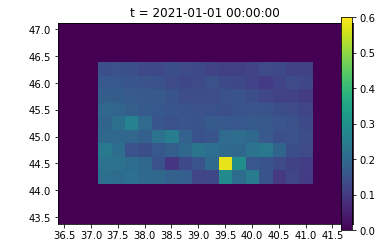

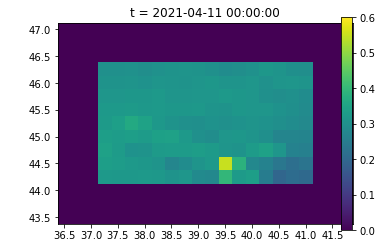

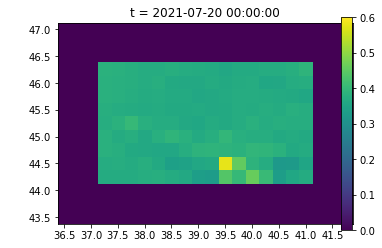

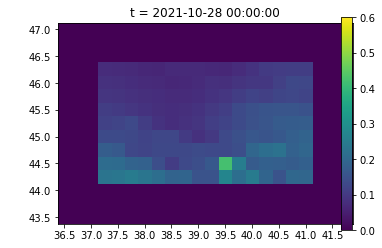

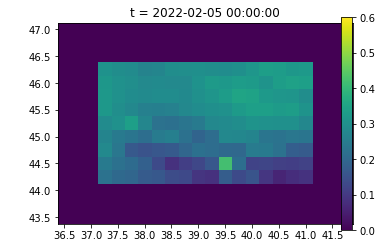

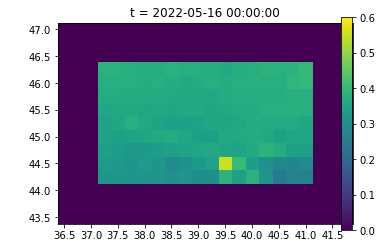

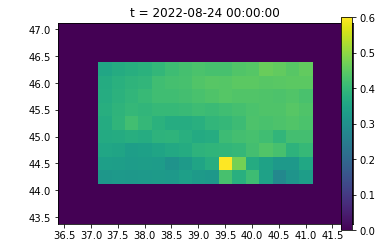

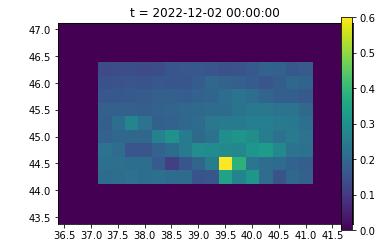

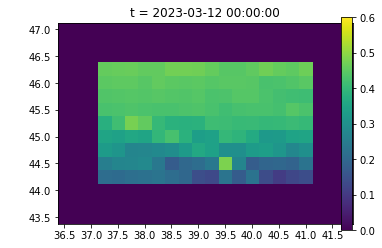

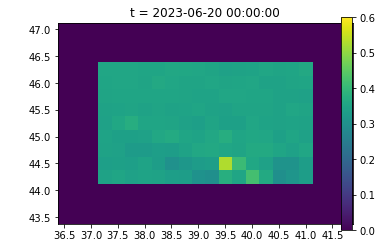

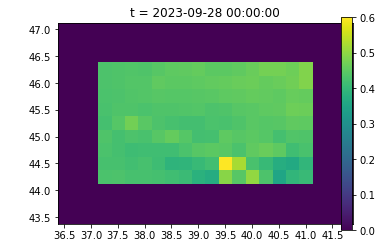

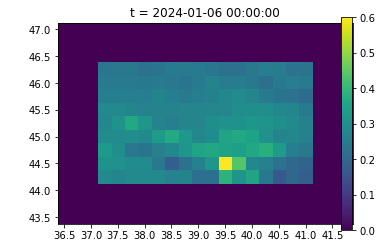

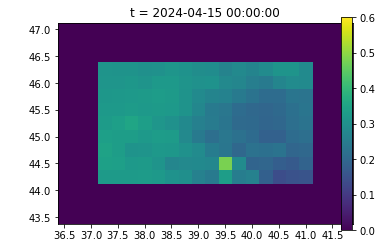

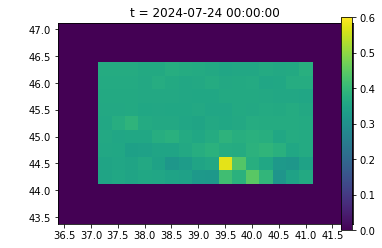

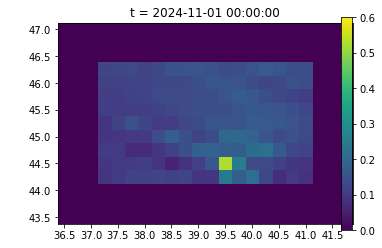

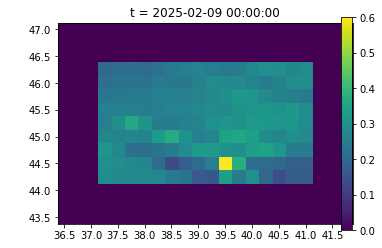

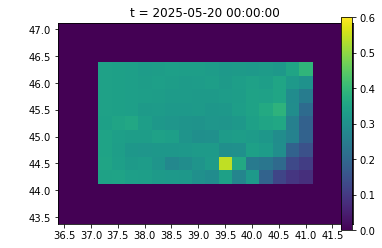

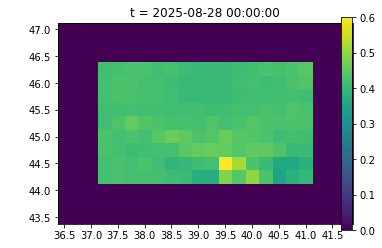

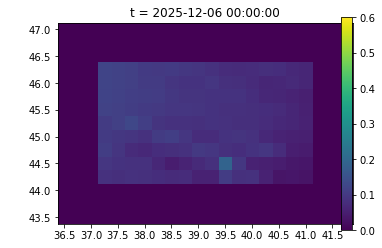

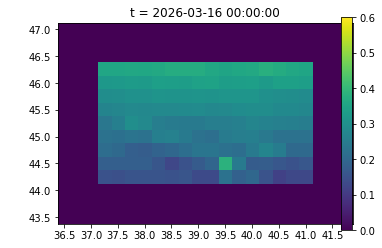

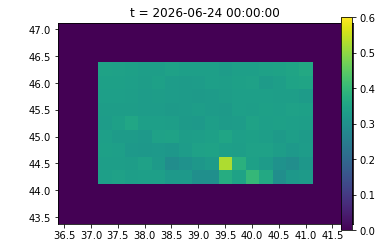

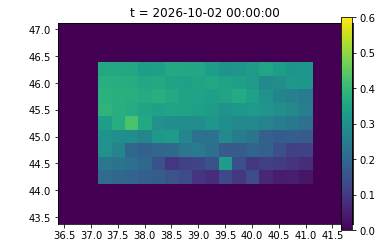

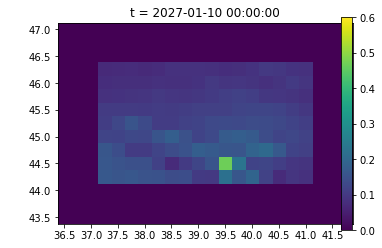

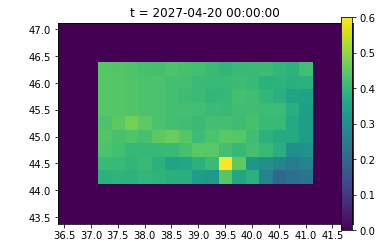

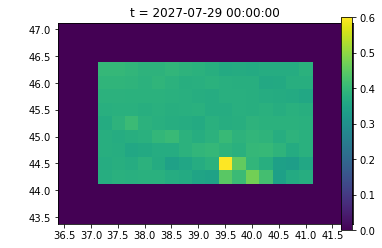

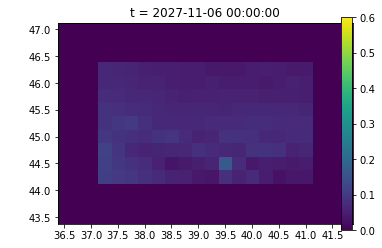

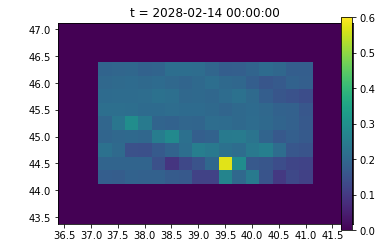

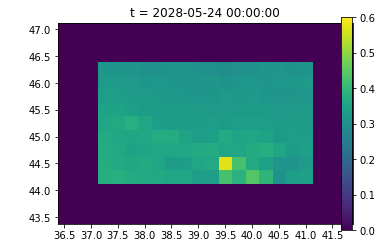

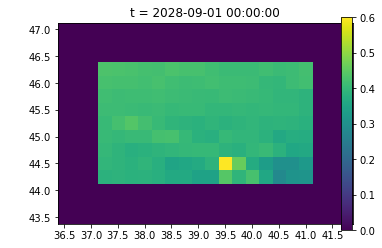

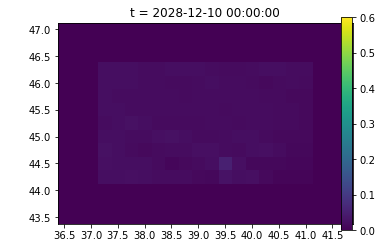

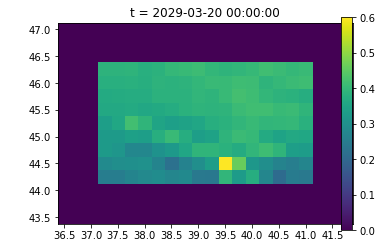

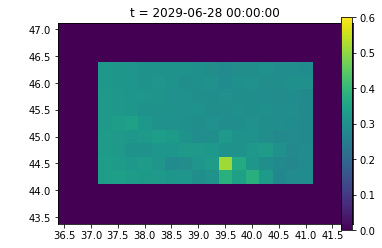

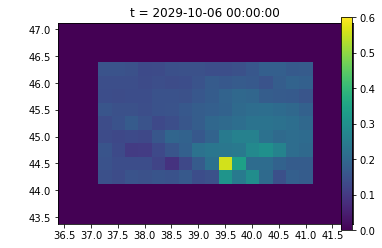

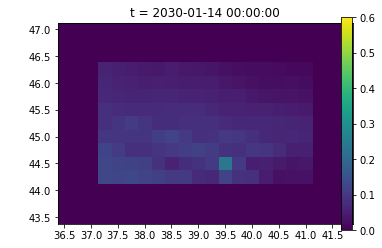

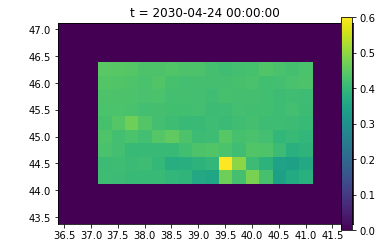

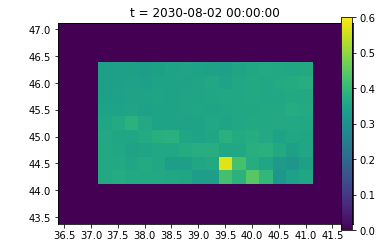

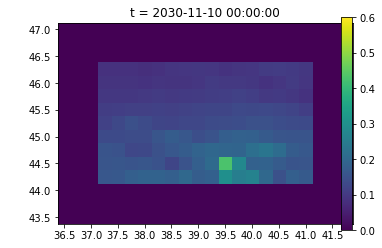

In [15]:
X = np.arange(36.5, 42.0, 0.5)#[36.5, 37.0, 37.5, 38.0, 38.5, 39.0, 39.5, 40.0, 40.5, 41.0, 41.5]
Y = np.arange(43.5, 47.5, 0.5)#[47.0, 46.5, 46.0, 45.5, 45.0, 44.5, 44.0, 43.5]


for t in list(range(grid_new.shape[0]))[::100]:
    data = grid_new[t, :, :]
    fig = plt.figure(figsize=(7, 3.7))

    ax = fig.add_subplot(111)
    ax.set_title('t = ' + str(start_date + pd.DateOffset(1) * t))
    plt.imshow(data,vmin=0, vmax=0.6)
    # plt.colorbar()
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(0,grid_new.shape[2],2), labels=X)
    ax.set_yticks(np.arange(grid_new.shape[1]-1,-1,-2), labels=Y)

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.set_frame_on(False)
    plt.colorbar(orientation='vertical')
    plt.savefig('tmp_dump/' + str(t) + '.png')
    # plt.show()

In [17]:
images = []
filenames = [os.path.join('tmp_dump', str(f) + '.png') for f in list(range(grid.shape[0]))[::100]]
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('tmp_dump/wind_prob_maps.gif', images, duration=0.5)

# Перенос на карту 

In [16]:
X_full = np.arange(36.5, 42, 0.25)
Y_full = np.arange(43.5, 47.25, 0.25)



In [4]:
a = [1,2,3,4,5,6,7,8,9]
for i in a[::1]:
    print(i)

1
2
3
4
5
6
7
8
9


In [26]:
df=map_to_pandas(grid=grid_new, x_axis=X_full, y_axis=Y_full, start_date=start_date)
df

0
16
32
48
64
80
96
112
128
144
160
176
192
208
224
240
256
272
288
304
320
336
352
368
384
400
416
432
448
464
480
496
512
528
544
560
576
592
608
624
640
656
672
688
704
720
736
752
768
784
800
816
832
848
864
880
896
912
928
944
960
976
992
1008
1024
1040
1056
1072
1088
1104
1120
1136
1152
1168
1184
1200
1216
1232
1248
1264
1280
1296
1312
1328
1344
1360
1376
1392
1408
1424
1440
1456
1472
1488
1504
1520
1536
1552
1568
1584
1600
1616
1632
1648
1664
1680
1696
1712
1728
1744
1760
1776
1792
1808
1824
1840
1856
1872
1888
1904
1920
1936
1952
1968
1984
2000
2016
2032
2048
2064
2080
2096
2112
2128
2144
2160
2176
2192
2208
2224
2240
2256
2272
2288
2304
2320
2336
2352
2368
2384
2400
2416
2432
2448
2464
2480
2496
2512
2528
2544
2560
2576
2592
2608
2624
2640
2656
2672
2688
2704
2720
2736
2752
2768
2784
2800
2816
2832
2848
2864
2880
2896
2912
2928
2944
2960
2976
2992
3008
3024
3040
3056
3072
3088
3104
3120
3136
3152
3168
3184
3200
3216
3232
3248
3264
3280
3296
3312
3328
3344
3360
3376
3392
3408
3

,index,date,lon,lat,value
0,0,2021-01-01 00:00:00,37.25,44.25,0.147081
1,1,2021-01-01 00:00:00,37.50,44.25,0.148060
2,2,2021-01-01 00:00:00,37.75,44.25,0.146804
3,3,2021-01-01 00:00:00,38.00,44.25,0.133293
4,4,2021-01-01 00:00:00,38.25,44.25,0.132312
...,...,...,...,...,...
52699,52699,2030-12-30 00:00:00,40.00,46.25,0.164474
52700,52700,2030-12-30 00:00:00,40.25,46.25,0.095561
52701,52701,2030-12-30 00:00:00,40.50,46.25,0.055296
52702,52702,2030-12-30 00:00:00,40.75,46.25,0.074107


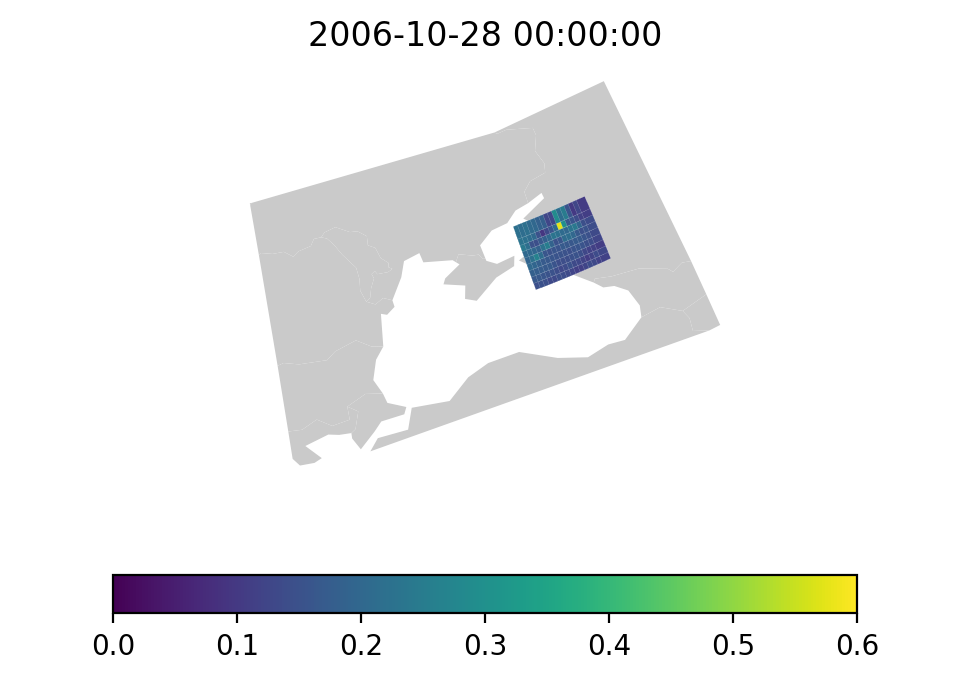

In [21]:
plot_map(df[df['date']=='2021-01-01 00:00:00'], 'value', part_world_to_plot='KK', vmin=0, vmax=0.6, text = '2006-10-28 00:00:00')

## Сохраняем изображения
нужно создать папку anim_future

In [28]:
column = 'value'

vmin = 0
vmax = 0.6

name = 0

for t in list(range(grid_new.shape[0]))[::10]:
    date = str(start_date + pd.DateOffset(1) * t)
    plot_map(df[df['date'] == date], column, part_world_to_plot='KK', vmin=vmin, vmax=vmax, 
             img_path=f'anim_future/{name}.jpg', text = date,
             show=False)
    print(name)
    name+=1
    plt.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Далее выполняем эту команду (нужна программа ffmpeg, на linux её можно установить с помощью ``sudo apt install ffmpeg``):

``ffmpeg -start_number 0 -framerate 10 -i anim_future/%d.jpg out.h264``